In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns

# Data crunching libraries
import numpy as np
import pandas as pd

# All utilities
import warnings
# filter warnings
warnings.filterwarnings('ignore')
import datetime
import time
import os
import zipfile
import sys
import re
import glob
import cv2
import gdown

# SK-learn libraries for learning.
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Handle parquet files
import pyarrow as pa
import pyarrow.parquet as pq
import gc

**Choose a random image to display for each sign**

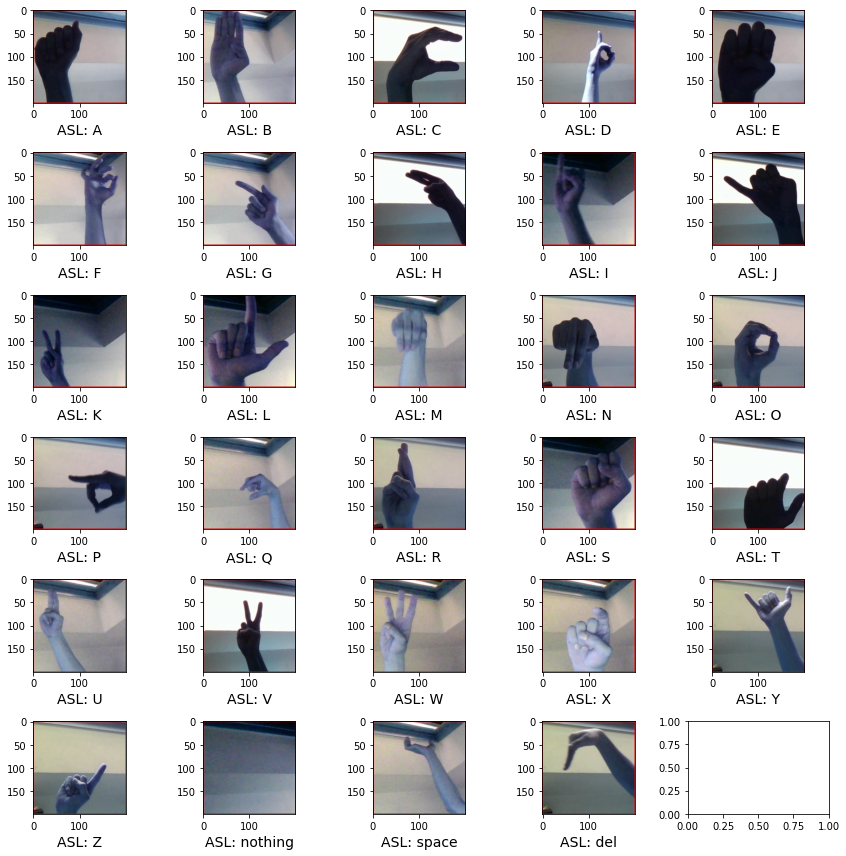

In [3]:
path='/content/ASL_Data_40K/archive_40k/asl_alphabet_train/asl_alphabet_train/'

X_train = []
y_train = []

labels = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P",
          "Q","R","S","T","U","V","W","X","Y","Z","nothing","space", "del"]

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 12))
row = 0
col = 0
raw_image_list = []
c0_hist_list = []
c1_hist_list = []
c2_hist_list = []

label_ind_dict = {} # dictionary to hold the label to index mapping

for label in labels:
    # get a list of all images (.jpg files) in a directory using glob.glob
    examples = glob.glob(path+label+"/*.jpg")
    img_cnt = 0 # for each label start with img_cnt set to 0
    print_flag = np.random.randint(0, len(examples)-1) # randomly select image 
    for image in examples:
        y_train.append(label)
        image1 = cv2.imread(image)
        if print_flag == img_cnt: 
            raw_image_list.append(image1) # add the image to the raw_image_list
            label_ind_dict[label] = img_cnt - 1 # save the index for that label
            # calculate the RGB values for the image and append to a list
            c0_hist_list.append(cv2.calcHist([image1], [0], None, [256], 
                                             [0,256]))
            c1_hist_list.append(cv2.calcHist([image1], [1], None, [256], 
                                             [0,256]))
            c2_hist_list.append(cv2.calcHist([image1], [2], None, [256], 
                                             [0,256]))
            ax = axes[row, col]
            ax.imshow(image1, cmap="gray") 
            ax.set_xlabel('ASL: '+label, fontsize=14) 
            col += 1
            if col % 5 == 0:
                row += 1
                col = 0
        img_cnt += 1
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        # gaussian blur
        image1 = cv2.GaussianBlur(image1.reshape(200,200), (5,5),0)
        image1 = cv2.Canny(image=image1.reshape(200,200), threshold1=100, 
                           threshold2=200)
        im_array = np.asarray(image1).reshape((200,200))
        X_train.append(im_array.flatten())
        
fig.tight_layout()
plt.show()

**Print sizes associated with the training data and the images inside training data**

In [4]:
# check the sizes of the trainining data 
print("Size of X_train:", len(X_train))
print("Size of y_train:", len(y_train))
print("Size of X_train entry:", len(X_train[0]))

Size of X_train: 87000
Size of y_train: 87000
Size of X_train entry: 40000


**Pick a random image to check gray scale conversion**

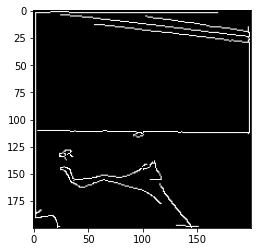

In [5]:
# check how the gray shades images show - pick a random one
plt.rc('image', cmap='gray')
plt.imshow(X_train[np.random.randint(1, len(X_train))].reshape(200,200))
plt.show()

**Gray scale images corresponding to the color images**

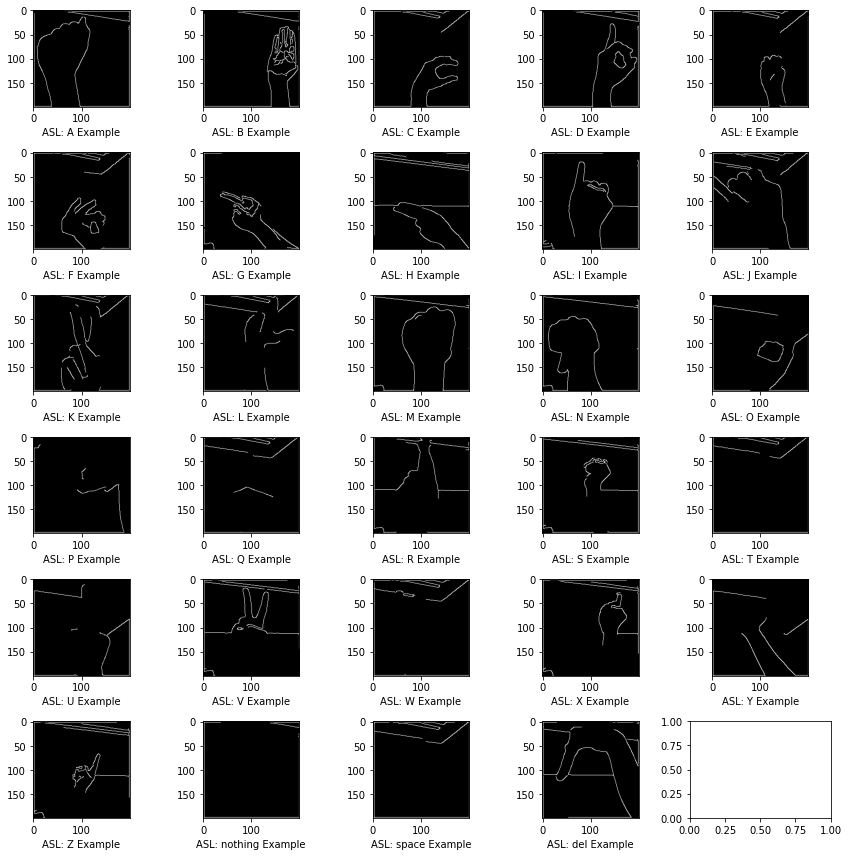

In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)

image_index_list = [] # init list to add digit example indexes to
# for each label find indices in y_train for that label and pick that 
# index that corresponds to label index that was printed earlier.
for label in labels:
    label_ind = np.where(y_train==label)[0][label_ind_dict[label]]
    image_index_list.append(label_ind)
    
plt.rc('image', cmap='gray')
fig, ax = plt.subplots(6, 5, figsize=(12,12))

counter = 0 # counter to be used for image index

for i in range(6):
    for num in range(5):
        if counter < 29:
            ind = image_index_list[counter]
            # Displaying image on correct subplot
            ax[i, num].imshow(X_train[ind].reshape(200,200))
            ax[i,num].set_xlabel('ASL: '+y_train[ind]+' Example')
            counter += 1

fig.tight_layout()
plt.show()

**RGB values for each image displayed earlier**

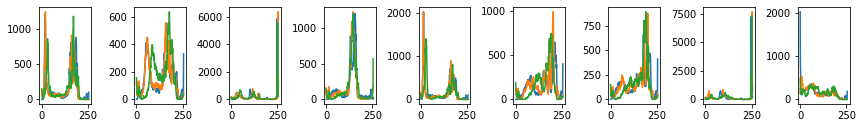

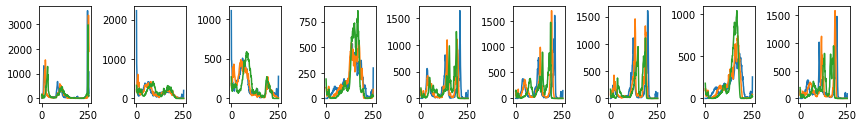

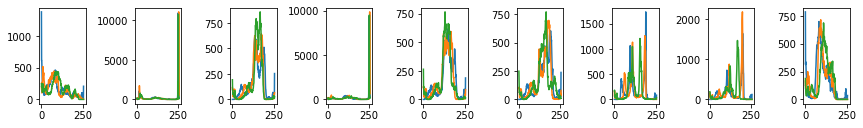

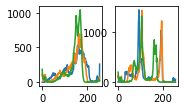

In [7]:
pos = 790 # control the positio of where we want to print the image
plt.figure(figsize=(12,12))
for i in range(len(raw_image_list)):
    pos += 1 # start with position 791: 9 images per row, starting from col 1
    plt.subplot(pos), plt.plot(c0_hist_list[i]), plt.plot(c1_hist_list[i]), 
    plt.plot(c2_hist_list[i])
    if pos == 799: # when 9 pictures have been accumulated
        pos = 790  # reset to 790, draw 
        plt.tight_layout() 
        plt.show() # draw the 9 pictures
        plt.figure(figsize=(12,12)) # reinit the drawing space

**For a random alphabet picked compare the original, and the gray scales.**

The letter chosen is: F


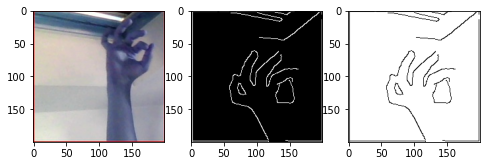

In [47]:
# Check the original image and gray scale images
rand_val = np.random.randint(0, 25) # pick a random letter
letter = labels[rand_val]
print("The letter chosen is:", letter)

fig, ax = plt.subplots(1, 3, figsize=(8,8))
plt.rc('image', cmap='gray')

ax[0].imshow(raw_image_list[rand_val]) # raw image

# get the index in y_train corresponding to the letter above
ind = np.where(y_train==letter)[0][label_ind_dict[letter]]
ax[1].imshow(X_train[ind].reshape(200,200)) # image with gray scale
ax[2].imshow(255 - X_train[ind].reshape(200,200)) 

plt.show()

In [ ]:
np.random.seed(42)

**Shuffle the X_train and y_train data and split into training and test sets.**

In [9]:
# shuffle and split data set into training and testing data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_train, x_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.25)

**Generate numeric labels corresponding to each alphabet**

In [20]:
le = sklearn.preprocessing.LabelEncoder()
le.fit(y_train)
print("Unqiue values of classes:")
print(le.classes_)
train_labels = le.transform(y_train)
test_labels = le.transform(y_test)
print("Associated label for each symbol:")
print(np.unique(train_labels))
print("Number of train samples:", len(train_labels))
print("Number of test samples:", len(test_labels))

Unqiue values of classes:
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'nothing' 'space']
Associated label for each symbol:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Number of train samples: 65250
Number of test samples: 21750


**Given the size of the image (200x200) any regression will take a long time. So, use PCA 
for dimensionality reduction**

In [11]:
def pca_transform(train_data, test_data, explainability=.80, size=1000):
    pca = PCA(explainability)
    pca.fit(train_data[:size])
    train = pca.transform(train_data)
    test = pca.transform(test_data)
    print("Features Reduced to {} Principal Components".format(len(test[0])))
    return train, test

pca_train, pca_test = pca_transform(X_train, x_test)

Features Reduced to 414 Principal Components


In [12]:
print(pca_train.shape, pca_test.shape, pca_train[0].shape)

(65250, 414) (21750, 414) (414,)


**Initialize logistic regression, fit data, and predict based on test data**

**Note**: *Going forward we'll use the variable train_labels and test_labels which contain integers between 0 and 28.*

Letter A -> 0, Letter B -> 1, ..., Letter Z -> 25

Symbol for "del" -> 26, Symbol for "nothing" -> 27, Symbol for "space" -> 28

In [13]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, train_labels)

LogisticRegression()

In [14]:
y_pred = clf.predict(x_test)

**Compute metrics**

In [15]:
f1 = metrics.f1_score(test_labels, y_pred, average='weighted')
accuracy = metrics.accuracy_score(test_labels, y_pred)
precision = metrics.precision_score(test_labels, y_pred, average='weighted')

print("******Weighted Metrics********")
print('    F1-score: {:.4f}\n'.format(f1))
print('    Accuracy: {:.4f}\n'.format(accuracy))
print('    Precision: {:.4f}'.format(precision))

print()
print("*****All weighted scores - precision, recall, F1, and Support*****")
print(metrics.precision_recall_fscore_support(
    test_labels, y_pred, average='weighted'))

print()
f1_l = metrics.f1_score(test_labels, y_pred, average=None)
precision_l = metrics.precision_score(test_labels, y_pred, average=None)
print("******Per-label Metrics********")
print("     F1 score:")
print(f1_l)
print("     Precision:")
print(precision_l)

******Weighted Metrics********
    F1-score: 0.9117

    Accuracy: 0.9117

    Precision: 0.9120

*****All weighted scores - precision, recall, F1, and Support*****
(0.9120247822752074, 0.9116781609195402, 0.9116732697936217, None)

******Per-label Metrics********
     F1 score:
[0.83599419 0.84108527 0.86618326 0.86715135 0.92216359 0.92975207
 0.90266667 0.89084746 0.92137752 0.91855808 0.94109772 0.95174263
 0.92297297 0.95488215 0.91966035 0.95148248 0.96158771 0.97024221
 0.94109682 0.93859082 0.8887468  0.86444008 0.85438233 0.86759814
 0.86020151 0.93297943 0.92266667 0.99242946 0.90921409]
     Precision:
[0.87009063 0.80869565 0.876      0.84974093 0.9270557  0.93360996
 0.90266667 0.90495868 0.91483871 0.90885073 0.94743935 0.96467391
 0.93051771 0.94156707 0.9025641  0.96448087 0.95183777 0.96823204
 0.94301221 0.94041451 0.88310038 0.87417219 0.84678523 0.88227334
 0.8591195  0.925      0.93135935 0.99448276 0.90431267]


**Compute the confusion matrix and draw the heatmap**

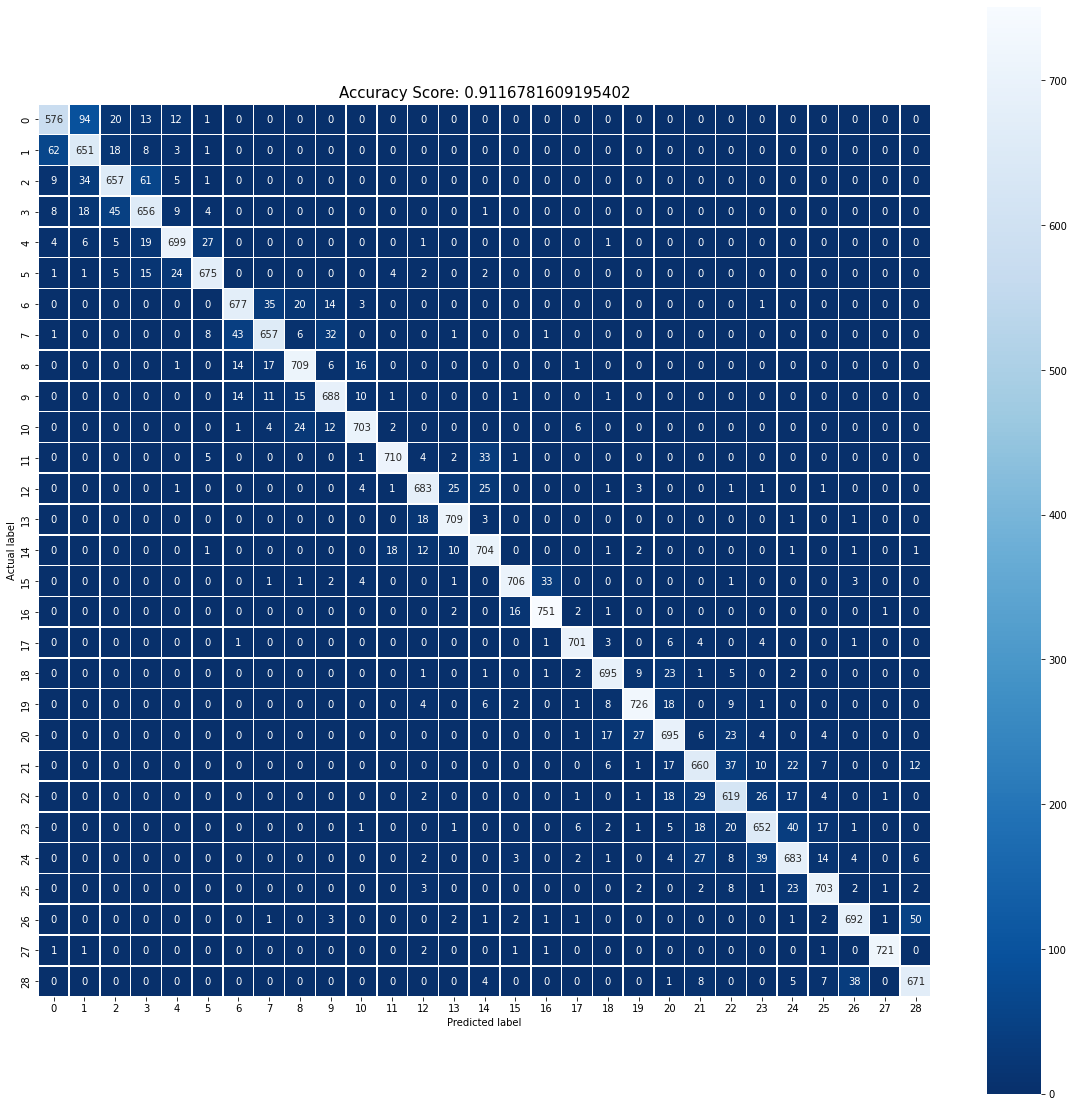

In [16]:
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt="0.0f", linewidths=.5, square = True, 
            cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title_cm = 'Accuracy Score: {0}'.format(accuracy)
plt.title(title_cm, size = 15);

**Run logistic regression with PCA reduced images and report scores**

In [17]:
clf_pca = LogisticRegression(solver='lbfgs')
clf_pca.fit(pca_train, train_labels)
y_pred_pca = clf_pca.predict(pca_test)

f1 = metrics.f1_score(test_labels, y_pred_pca, average='weighted')
accuracy = metrics.accuracy_score(test_labels, y_pred_pca)
precision = metrics.precision_score(test_labels, y_pred_pca, average='weighted')

print("******Weighted Metrics********")
print('    F1-score: {:.4f}\n'.format(f1))
print('    Accuracy: {:.4f}\n'.format(accuracy))
print('    Precision: {:.4f}'.format(precision))

print()
print("*****All weighted scores - precision, recall, F1, and Support*****")
print(metrics.precision_recall_fscore_support(
    test_labels, y_pred_pca, average='weighted'))

print()
f1_l = metrics.f1_score(test_labels, y_pred_pca, average=None)
precision_l = metrics.precision_score(test_labels, y_pred_pca, average=None)
print("******Per-label Metrics********")
print("     F1 score:")
print(f1_l)
print("     Precision:")
print(precision_l)

******Weighted Metrics********
    F1-score: 0.8843

    Accuracy: 0.8844

    Precision: 0.8846

*****All weighted scores - precision, recall, F1, and Support*****
(0.8845994089104278, 0.884367816091954, 0.8843050480619231, None)

******Per-label Metrics********
     F1 score:
[0.78363384 0.76860068 0.83289817 0.8206158  0.90769231 0.91316527
 0.89290495 0.90081522 0.90673575 0.91093117 0.91447368 0.92747838
 0.87907609 0.90933879 0.86727989 0.93539704 0.95646607 0.93646409
 0.92729767 0.91309824 0.87565445 0.84013378 0.82626539 0.80505655
 0.83125    0.91906355 0.89255109 0.99314129 0.85828343]
     Precision:
[0.77823691 0.77977839 0.83398693 0.81407703 0.88721805 0.93276109
 0.89650538 0.91701245 0.8974359  0.91093117 0.90494792 0.9330656
 0.89118457 0.90748299 0.85603113 0.94686649 0.94676806 0.93259972
 0.94150418 0.89175892 0.89081225 0.86860304 0.81182796 0.81867388
 0.82403965 0.9184492  0.89078947 0.99178082 0.83875163]


**Confusion matrix computation**

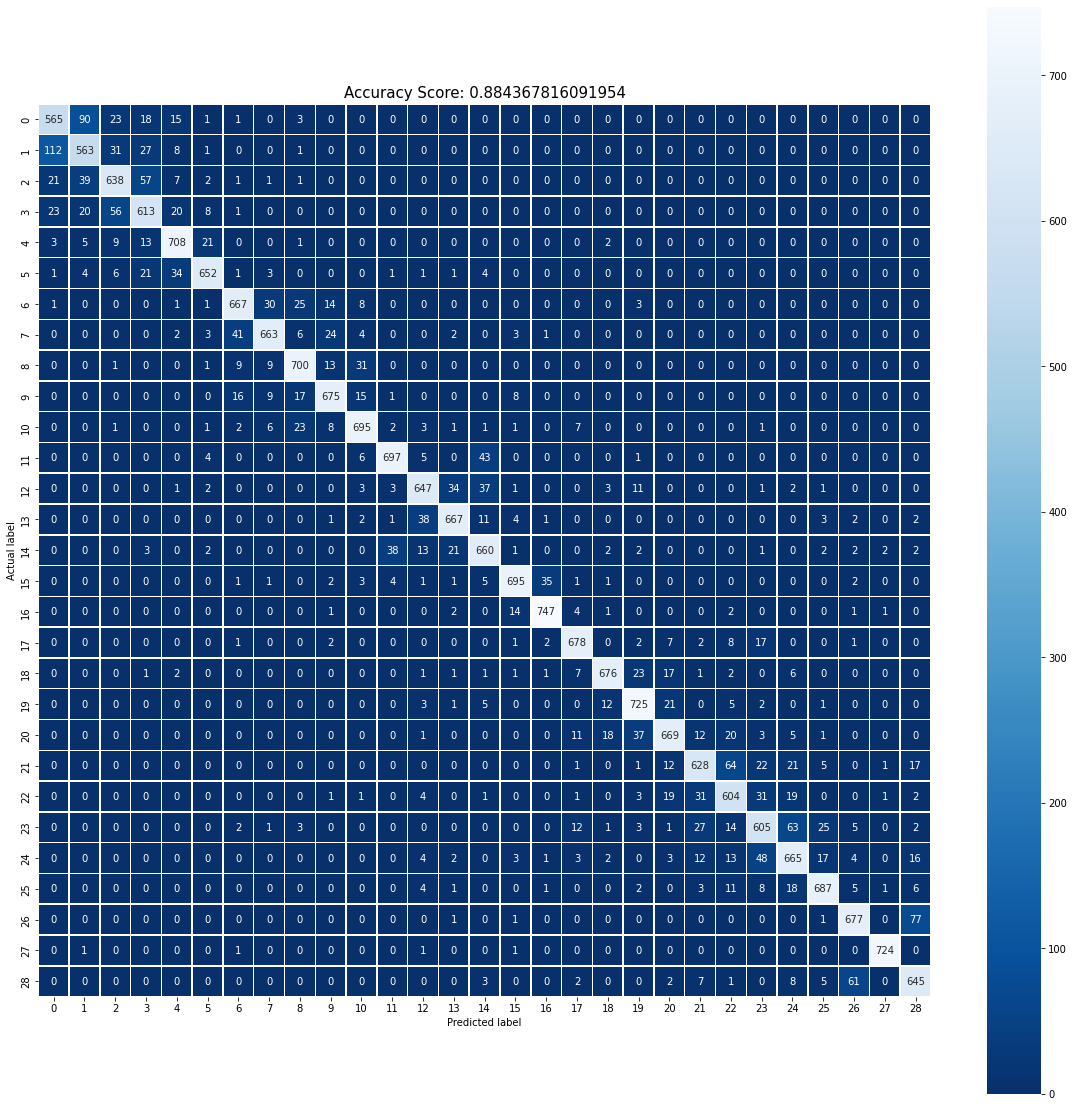

In [18]:
cm = confusion_matrix(test_labels, y_pred_pca)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt="0.0f", linewidths=.5, square = True, 
            cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title_cm = 'Accuracy Score: {0}'.format(accuracy)
plt.title(title_cm, size = 15);

**Generate the AUC-ROC curve**

In [35]:
pred_prob = clf.predict_proba(x_test)

fpr = {}
tpr = {}
thresh ={}

for i in range(len(np.unique(test_labels))):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels, pred_prob[:,i], 
                                          pos_label=i)
    
pred_prob_pca = clf_pca.predict_proba(pca_test)

fpr_pca = {}
tpr_pca = {}
thresh_pca ={}

for i in range(len(np.unique(test_labels))):    
    fpr_pca[i], tpr_pca[i], thresh_pca[i] = roc_curve(test_labels, 
                                                      pred_prob_pca[:,i], 
                                                      pos_label=i)

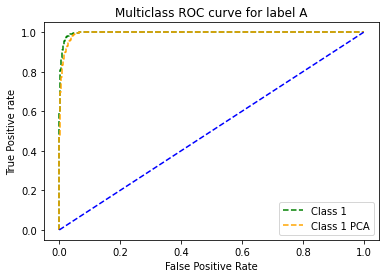

In [45]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

rand_val = np.random.randint(0, 28)
plt.plot(fpr[rand_val], tpr[rand_val], linestyle='--',color='green', 
         label='Class 1')
plt.plot(fpr_pca[rand_val], tpr_pca[rand_val], linestyle='--', color='orange', 
         label='Class 1 PCA')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Multiclass ROC curve for label ' + labels[rand_val])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

**Sum of squared weights for the non-PCA and PCA models**

In [19]:
print("Sum of squares of weights")
sum_sq_wt = []
sum_sq_wt_pca = []
for i in range(len(np.unique(test_labels))):
    sum_sq_wt.append(round(np.sum(clf.coef_[i]**2), 4))
    sum_sq_wt_pca.append(round(np.sum(clf_pca.coef_[i]**2), 4))

df = pd.DataFrame({"sum_square_weights": sum_sq_wt,
     "sum_square_weights_pca": sum_sq_wt_pca})
print(df)

Sum of squares of weights
    sum_square_weights  sum_square_weights_pca
0               0.0035                  0.0032
1               0.0035                  0.0030
2               0.0031                  0.0030
3               0.0030                  0.0024
4               0.0028                  0.0024
5               0.0026                  0.0028
6               0.0031                  0.0020
7               0.0031                  0.0022
8               0.0025                  0.0022
9               0.0027                  0.0023
10              0.0023                  0.0025
11              0.0022                  0.0026
12              0.0028                  0.0025
13              0.0029                  0.0027
14              0.0024                  0.0021
15              0.0030                  0.0025
16              0.0024                  0.0023
17              0.0026                  0.0025
18              0.0022                  0.0026
19              0.0019            